# Pipeline for analysing open clusters based on Gaia DR2 data

## 1 - Libraries

In [2]:
#%matplotlib notebook

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy
import astropy.stats as ap

from math import pi
from astropy import units
from astropy.table import Table
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord

#print(scipy.stats.__doc__)
#dir(scipy.stats)

## 2 - Query Gaia DR2 Catalog

In [726]:
# Gaia DR2 catalog on VizieR
# see https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=I/345/gaia2
cat = 'I/345/gaia2'
cols = ['_r', 'DR2Name', 'RAdeg', 'DEdeg', 'Plx', 'e_Plx', 'pmRA', 'pmDE', 'Gmag', 'BP-G']
filters = {'Plx' : '0..5', 'e_Plx' : '<0.7', 'pmRA' : '-20..20', 'pmDE' : '-20..20', 'Gmag' : '<17'}
row_lim = 1000
timeout = 600

#Query the GDR2 data for one cluster
def query(name, ra_deg, de_deg, rad, filter_map, max_stars = 1000):
    print("Querying VizieR for %s ..." % name)
    coo = SkyCoord(ra = ra_deg*units.degree, dec = de_deg*units.degree, frame = 'icrs')
    viz = Vizier(columns = cols, column_filters = filter_map, row_limit = row_lim, timeout = timeout)
    viz_res = viz.query_region(coo, radius = rad*units.degree, catalog = cat)
    if viz_res == None or len(viz_res) == 0:
        print(viz_res)
        return pd.DataFrame() #Empty Dataframe
    df = viz_res[0].to_pandas()
    df = df.set_index('DR2Name')
    df = df.sort_values(by='Gmag')
    df = df[:max_stars]
    df = df.sort_values(by='_r')
    return df

#cl_name, cl_ra, cl_de, radius = 'Alessi_62', 284.026, +21.597, 0.256

df = query(cl_name, cl_ra, cl_de, radius, filters)
if not df.empty:
    #display(df.head())
    display(df.describe())
else:
    print('Empty dataframe! - try again with another set of parameters')

Querying VizieR for deWit_2 ...


,_r,_RAJ2000,_DEJ2000,Plx,e_Plx,pmRA,pmDE,Gmag,BP-G
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,201.000000
mean,0.049328,105.339188,-3.115119,0.556864,0.060028,-0.843578,-0.561466,15.385189,0.447230
std,0.020176,0.035805,0.039622,0.363971,0.025651,2.405132,3.338503,1.456684,0.201857
min,0.003325,105.260027,-3.191421,0.013900,0.025200,-14.746000,-18.481000,7.672500,-0.053900
25%,0.035688,105.313805,-3.146246,0.313650,0.037500,-1.600750,-1.733250,14.554200,0.341500
50%,0.053326,105.338287,-3.117746,0.493250,0.058350,-0.937000,0.031000,15.705500,0.420300
75%,0.065877,105.367558,-3.083844,0.633275,0.077900,-0.030000,0.786750,16.440925,0.536100
max,0.079948,105.414036,-3.042179,2.224100,0.180200,13.119000,13.039000,16.950500,1.222700


## 3 - VPD scatter plot and 2D Histogram (returning PMs for the bin with highest count)

deWit_2               ; 105.340000; -3.117000;  0.08000;  0.367; 0.126;  -0.90;  0.42;   0.55;  0.41;   91;  7.67..16.95


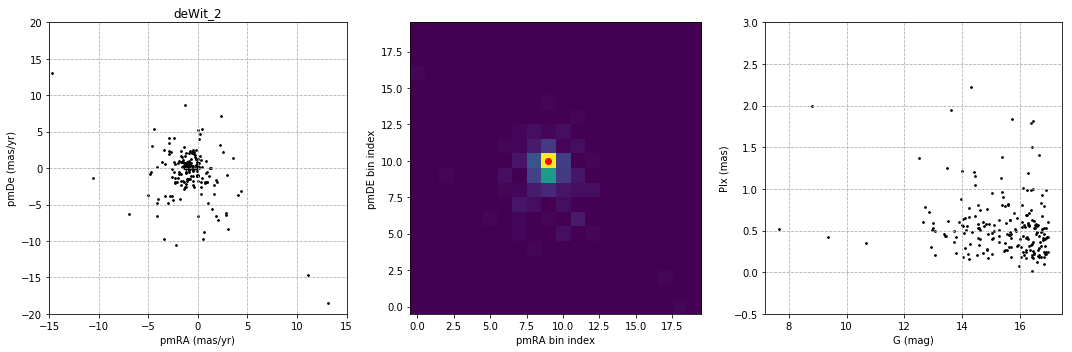

In [727]:
## determine limits for dimensioning the VPD
def pm_limits(pmras, pmdes):
    def get_lim_pm(max_pm):
        return  5 if max_pm <=  5 else \
               10 if max_pm <= 10 else \
               15 if max_pm <= 15 else \
               20 if max_pm <= 20 else \
               25 if max_pm <= 25 else \
               30 if max_pm <= 30 else \
               35 if max_pm <= 35 else \
               40 if max_pm <= 40 else \
               45 if max_pm <= 45 else 60
    max_pm = np.max([np.abs(np.min(pmras)), np.abs(np.max(pmras))])
    max_pmRA = get_lim_pm(max_pm)
    min_pmRA = -1 * max_pmRA
    max_pm = np.max([np.abs(np.min(pmdes)), np.abs(np.max(pmdes))])
    max_pmDe = get_lim_pm(max_pm)
    min_pmDe = -1 * max_pmDe
    return min_pmRA, max_pmRA, min_pmDe, max_pmDe
 
def plx_limits(plxs, min_plx = -0.5):
    max_plx = np.max(plxs)
    max_plx = 3 if max_plx <= 3 else \
              4 if max_plx <= 4 else \
              5 if max_plx <= 5 else \
              6 if max_plx <= 6 else \
              8 if max_plx <= 8 else \
             10 if max_plx <= 10 else \
             12 if max_plx <= 12 else 16
    return min_plx, max_plx

def mag_limits(gmags, color_mag_incr = 0.5):
    min_gmag = np.min(gmags) - color_mag_incr
    max_gmag = np.max(gmags) + color_mag_incr
    return min_gmag, max_gmag

# Build a VPD (Vector Proper Motion Diagram) scatter plot
def plot_VPD(data, title):
    pmras = data['pmRA']
    pmdes = data['pmDE']
    min_pmRA, max_pmRA, min_pmDe, max_pmDe = pm_limits(pmras, pmdes)
    xs, ys = pmras, pmdes
    plt.title(title)
    plt.xlabel('pmRA (mas/yr)')
    plt.ylabel('pmDe (mas/yr)')
    plt.xlim(min_pmRA, max_pmRA)
    plt.ylim(min_pmDe, max_pmDe)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Calculates the median parallax of the stars within <limit> of the estimated pms
def calculate_estimates(data, est_pmra, est_pmde, limit = 1.5):
    def filter_pms(pmra, pmde):
        return (abs(est_pmra - pmra) < limit) and (abs(est_pmde - pmde) < limit)
    filter_fn = lambda x: filter_pms(x['pmRA'], x['pmDE'])
    data = data[data.apply(filter_fn, axis = 1)]
    plxs = data['Plx']
    pmra = data['pmRA']
    pmde = data['pmDE']
    gmag = data['Gmag']
    plx, err_plx = np.median(plxs), ap.median_absolute_deviation(plxs)
    pmra, err_pmra = np.median(pmra), ap.median_absolute_deviation(pmra)
    pmde, err_pmde = np.median(pmde), ap.median_absolute_deviation(pmde)
    gmin, gmax = np.min(gmag), np.max(gmag)
    return plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, len(plxs)

# Build 2D histogram for proper motions and returns average PMs for the bin with the highest count
def plot_pm_hist(data, num_bins = 20):
    xs = data['pmRA']
    ys = data['pmDE']
    min_pmRA, max_pmRA, min_pmDe, max_pmDe = pm_limits(xs, ys)
    _range = [[min_pmRA, max_pmRA], [min_pmDe, max_pmDe]]
    counts, xedges, yedges = np.histogram2d(xs, ys, bins = num_bins, range = _range)
    x_ind, y_ind = np.unravel_index(np.argmax(counts), counts.shape)
    est_pmRA = (xedges[x_ind] + xedges[x_ind+1]) / 2
    est_pmDe = (yedges[y_ind] + yedges[y_ind+1]) / 2
    plt.imshow(counts.T, origin = 'lower')
    plt.xlabel('pmRA bin index')
    plt.ylabel('pmDE bin index')
    plt.plot(x_ind, y_ind, 'or')
    plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n = calculate_estimates(data, est_pmRA, est_pmDe)
    return plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n

# Build G mag X Parallax scatter plot
def plot_mag_par(data):
    plxs = data['Plx']
    gmags = data['Gmag']
    min_gmag, max_gmag = mag_limits(gmags)
    min_plx, max_plx = plx_limits(plxs)
    xs, ys = gmags, plxs
    plt.xlabel('G (mag)')
    plt.ylabel('Plx (mas)')
    plt.xlim(min_gmag, max_gmag)
    plt.ylim(min_plx, max_plx)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# plot both graphics side-by-side
def plot_step1(data, cl_name):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(131)
    plot_VPD(data, cl_name)
    plt.subplot(132)
    plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n = plot_pm_hist(data)
    plt.subplot(133)
    plot_mag_par(data)
    plt.tight_layout()
    return plx, err_plx, pmra, err_pmra, pmde, err_pmde, gmin, gmax, n

est_plx, err_plx, est_pmRA, err_pmRA, est_pmDe, err_pmDe, gmin, gmax, n = plot_step1(df, cl_name)
estimates = f'{cl_name:<22}; {cl_ra:9.6f}; {cl_de:+9.6f}; {radius:8.5f};  '
estimates += f'{est_plx:5.3f}; {err_plx:5.3f}; {est_pmRA:6.2f};{err_pmRA:6.2f}; {est_pmDe:6.2f};{err_pmDe:6.2f};'
estimates += f'{n:>5}; {gmin:5.2f}..{gmax:5.2f}'
print(estimates)


## 4 - Query a larger area constrained by the estimated values

In [ ]:
mult_rad = 5
mul_pm = 1.5
mul_px = 2
plx_lim = (est_plx - mul_px*err_plx, est_plx + mul_px*err_plx)
plx_range = f'{plx_lim[0]:.2f}..{plx_lim[1]:.2f}'
pmRA_lim = (est_pmRA - mul_pm*0.7*err_pmRA, est_pmRA + mul_pm*0.7*err_pmRA)
pmRA_range = f'{pmRA_lim[0]:.2f}..{pmRA_lim[1]:.2f}'
pmDe_lim = (est_pmDe - mul_pm*err_pmDe, est_pmDe + mul_pm*err_pmDe)
pmDe_range = f'{pmDe_lim[0]:.2f}..{pmDe_lim[1]:.2f}'
gmag_range = f'{gmin:.2f}..{gmax:.2f}'
filters2 = {'Plx' : plx_range, 'pmRA' : pmRA_range, 'pmDE' : pmDe_range, 'Gmag' : gmag_range}
rdp_lim = radius * mult_rad
print(filters2)
df2 = query(cl_name, cl_ra, cl_de, rdp_lim, filters2, max_stars = row_lim)
#display(df2.head())
#display(df2.describe())
plot_step1(df2, cl_name)


## 5 - Chart  and RDP scatter plot (constrained by the estimated values)

In [25]:

# Build chart scatter plot
def plot_chart(data, title):
    xs, ys = data['_RAJ2000'], data['_DEJ2000']
    plt.title(title)
    plt.xlabel('RA (degrees)')
    plt.ylabel('De (degrees)')
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Build RDP (Radial Density Profile) scatter plot
def plot_RDP(data, title = None):
    bins = data['_r'].value_counts(bins=25).sort_index()
    intervals = bins.index.to_tuples()
    midpoints = [i.mid for i in bins.index]
    counts = bins.values
    zipped = tuple(zip(intervals, midpoints, counts))
    densities = [count / ring_area(inner*60, outer*60) for ((inner, outer), midpoint, count) in zipped]
    log_dens = [np.log10(dens) if dens > 0 else 0 for dens in densities]
    print(bins)
    #print(intervals)
    #print(midpoints)
    #print(counts)
    #print(zipped)
    plt.grid(True, linestyle='dashed')
    plt.title(title)
    plt.xlabel('Radius (degrees)')
    plt.xticks([i for i,j in intervals], rotation='vertical')
    plt.ylabel('Logarithm of Star Density (stars/arcmin^2)')
    plt.scatter(midpoints, log_dens, s=6, color='black')

# plot both graphics side-by-side
def plot_step2(data, cl_name):
    fig = plt.figure(figsize=(15,6))
    plt.subplot(121)
    plot_chart(data, cl_name)
    plt.subplot(122)
    plot_RDP(data, cl_name)
    plt.tight_layout()

def ring_area(inner_rad, outer_rad):
    return pi * (outer_rad**2 - inner_rad**2)
    
plot_step2(df2, cl_name)


NameError: name 'df2' is not defined

## 6 - CMD

In [ ]:
# Build G mag X Parallax scatter plot
def plot_mag_par(data, title = None):
    plxs = data['Plx']
    gmags = data['Gmag']
    min_gmag, max_gmag = mag_limits(gmags)
    min_plx, max_plx = plx_limits(plxs)
    xs, ys = gmags, plxs
    if title:
        plt.title(title)
    plt.xlabel('G (mag)')
    plt.ylabel('Plx (mas)')
    plt.xlim(min_gmag, max_gmag)
    plt.ylim(min_plx, max_plx)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

# Build CMD (Color-Magnitude Diagram) scatter plot
def plot_CMD(data, title = None):
    gmags = data['Gmag']
    colors = data['BP-G']
    min_gmag, max_gmag = mag_limits(gmags)
    min_color, max_color = mag_limits(colors)
    xs, ys = colors, gmags
    if title:
        plt.title(title)
    plt.xlabel('BP-G (mag)')
    plt.ylabel('G (mag)')
    plt.xlim(min_color, max_color)
    plt.ylim(max_gmag, min_gmag)
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')

chosen_lim_radius = 1.15 #choose one based on the RDP printed above
df3 = df2[df2['_r'] < chosen_lim_radius]
#plot_mag_par(df3, cl_name)
plot_CMD(df3, cl_name)
